### Required Imports


In [1]:
import sys
import os
sys.path.insert(0, 'core/')
from analysis import create_denoising_dataset
import nibabel as nib, scipy.io as sio
from utils import list_to_nib
from tkinter import Tk
from tkinter.filedialog import askdirectory

### Set Path for Files

In [2]:
# hide the tk root window
Tk().withdraw() 

# user specify data directory
# print('Select directory containing the phantom data, log file, and acqtime file')
mainpath = askdirectory(title = 'Path to Phantom Data')

# make output directory
outpath = mainpath + '/Extracted Time Series'
os.makedirs(outpath, exist_ok = True)

In [3]:
# set path for input files 
epi_path = mainpath + '/epi/epi_corrected.nii' # Path of intensity nonuniformity corrected fMRI measurement in nifti format.
log_path = mainpath + 'epi/log.csv' # Path of phantom-log file obtained from your BrainDancer device.
acqtimes_path = mainpath + 'Acqtimes.csv' # Path of slice-acquistion order of your acquistion protocol in csv format.

In [4]:
# set path for output files
ground_truth_ts = outpath + '/groundtruth.nii' # Path for saving the ground truth.
measured_fmri_ts = outpath + '/measured.nii' # Path for saving the extracted measured fMRI time series. 
masks = outpath + '/masks.nii' # Path for saving masks of the extracted slices. 
center_rotation = outpath + '/center.mat' # Path for saving the center of rotation used for creating ground-truth. 
slices = outpath + '/slices.mat' # Path for saving a log of slices used for ground-truth and measured fMRI time series. 

In [5]:
%matplotlib ipympl
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.widgets import RangeSlider


In [44]:
def display_all_slices(data,volume_number):
    data_read = data
    count = 1
    dim = data_read.header['dim'][3] 
    fig = plt.figure(figsize=(10,dim-2)) # reduce the subplot size to make the plot tighter 
    lowThres = 0 # initiation the two variables for detecting bad slices 
    highThres = dim
    
    for i in range(dim):
        fig.subplots_adjust(hspace=0, wspace=0.0005)      
        ax = fig.add_subplot(int(dim/4 +1) ,4, count) # non-integer results are given from the calculation
        im= plt.imshow(data_read.get_fdata()[:,:,i,volume_number])
        ax.set_title('Slice '+str(i),fontsize=18)
        ax.set_axis_off()
        count+=1
        
    # update function for the slider bar
    def update(val): 
        # Update the threshold for color map
        lowThres = val[0]
        highThres = val[1]

        # Redraw the figure to ensure it updates
        fig.canvas.draw_idle()

    plt.tight_layout()
    slider_ax = plt.axes([0.20, 1/(dim/4+3), 0.60, 0.03])
    slider = RangeSlider(slider_ax, "Threshold", 0, dim)
    slider.on_changed(update)
    plt.show()

In [144]:
import math
from PIL import Image
import numpy as np

In [181]:
def display_all_slices(data,volume_number, dim, lowThres = 0, highThres = data_read.header['dim'][3]):
    # lowThres: slice threshold for highpass 
    # highThres: slice threshold for lowpass 
    
    count = 1
    fig = plt.figure(figsize=(10,dim-2)) # reduce the subplot size to make the plot tighter 
    
    for i in range(dim):
        arr = data_read.get_fdata()[:,:,i,volume_number]
        fig.subplots_adjust(hspace=0, wspace=0.0005)      
        ax = fig.add_subplot(int(dim/4 +1) ,4, count) # non-integer results are given from the calculation
        if i <= lowThres or i > highThres-1:
            # arrGray = (arr-np.amax(arr[0]))/np.amax(arr[0])*200
            # arrGray = (arr > arr.mean()).astype(int)
            plt.gray()
            im = plt.imshow(arr)
            #img = Image.fromarray(arr)
        else: 
            plt.viridis()
            im = plt.imshow(img)
        
        #im= plt.imshow(img)
        ax.set_title('Slice '+str(i),fontsize=18)
        ax.set_axis_off()
        count+=1


# update function for the slider bar
def update(val): 
    # Update the threshold for color map
    lowThres = val[0]
    highThres = val[1]
    
    # Redraw the figure to ensure it updates
    fig.canvas.draw_idle()

    # return the parameters 
    return lowThres, highThres


In [ ]:
class slices_show: 
    def __init__(self, lowThres, highThres):
        self.lowThres = lowThres
        self.highThres = highThres
        
    def display_all_slices(self, data,volume_number, dim):
        # lowThres: slice threshold for highpass 
        # highThres: slice threshold for lowpass 
        lowThres = self.lowThres
        highThres = self.highThres

        count = 1
        fig = plt.figure(figsize=(10,dim-2)) # reduce the subplot size to make the plot tighter 

        for i in range(dim):
            arr = data_read.get_fdata()[:,:,i,volume_number]
            fig.subplots_adjust(hspace=0, wspace=0.0005)      
            ax = fig.add_subplot(int(dim/4 +1) ,4, count) # non-integer results are given from the calculation
            if i <= lowThres or i > highThres-1:
                # arrGray = (arr-np.amax(arr[0]))/np.amax(arr[0])*200
                # arrGray = (arr > arr.mean()).astype(int)
                plt.gray()
                im = plt.imshow(arr)
                #img = Image.fromarray(arr)
            else: 
                plt.viridis()
                im = plt.imshow(img)

            #im= plt.imshow(img)
            ax.set_title('Slice '+str(i),fontsize=18)
            ax.set_axis_off()
            count+=1

In [6]:
class Thresholds:
    """observable""" 
    def __init__(self):
        """create an empty observer list"""
        self._observers = []
    def notify(self, modifier = None):
        """Alert the observers"""
        for observer in self._observers:
            if modifier != observer:
                observer.update(Thres)
    def attach(self, observer):
        """If the observer is not in the list,
        append it into the list"""
        if observer not in self._observers:
            self._observers.append(observer)
    def detach(self, observer):
        """Remove the observer from the observer list"""
        try:
            self._observers.remove(observer)
        except ValueError:
            pass

class Data(Thresholds):
 
    """observer"""
 
    def __init__(self, data, volume_number):
        Thresholds.__init__(self)
        self._lowThres = 0 
        self._highThres = data.header['dim'][3] 
        self.data = data
        self.volume_number = volume_number
 
    @property
    def lowThres(self):
        return self._lowThres
 
    @lowThres.setter
    def lowThres(self, value):
        self._lowThres = value
        self.notify()
        
    @property
    def highThres(self):
        return self._highThres
 
    @highThres.setter
    def highThres(self, value):
        self._highThres = value
        self.notify()


class slices_show: 
    def update(self, Thresholds, data, volume_number):
        # lowThres: slice threshold for highpass 
        # highThres: slice threshold for lowpass 
        lowThres = Thresholds.lowThres
        highThres = Thresholds.highThres
        data = Thresholds.data
        volume_number = Thresholds.volume_number
        dim = data.header['dim'][3] 
        
        count = 1
        fig = plt.figure(figsize=(10,dim-2)) # reduce the subplot size to make the plot tighter 

        for i in range(dim):
            arr = data_read.get_fdata()[:,:,i,volume_number]
            fig.subplots_adjust(hspace=0, wspace=0.0005)      
            ax = fig.add_subplot(int(dim/4 +1) ,4, count) # non-integer results are given from the calculation
            if i <= lowThres or i > highThres-1:
                # arrGray = (arr-np.amax(arr[0]))/np.amax(arr[0])*200
                # arrGray = (arr > arr.mean()).astype(int)
                plt.gray()
                im = plt.imshow(arr)
                #img = Image.fromarray(arr)
            else: 
                plt.viridis()
                im = plt.imshow(img)

            #im= plt.imshow(img)
            ax.set_title('Slice '+str(i),fontsize=18)
            ax.set_axis_off()
            count+=1
        plt.show()

In [7]:
class Thresholds:
    """subscriber""" 
    
    def __init__(self):
        """create an empty observer list"""
        self._observers = []
        
    def notify(self, Thres):
        """Alert the observers"""
        for observer in self._observers:
            observer.update(Thres)
                
    def attach(self, observer):
        """If the observer is not in the list,
        append it into the list"""
        if observer not in self._observers:
            self._observers.append(observer)
            
    def detach(self, observer):
        """Remove the observer from the observer list"""
        try:
            self._observers.remove(observer)
        except ValueError:
            pass

class Data(Thresholds):
 
    """observer"""
 
    def __init__(self, data, volume_number):
        Thresholds.__init__(self)
        self._lowThres = 0 
        self._highThres = data.header['dim'][3] 
        self.data = data
        self.volume_number = volume_number
 
    @property
    def lowThres(self):
        return self._lowThres
 
    @lowThres.setter
    def lowThres(self, value):
        self._lowThres = value
        self.notify()
        
    @property
    def highThres(self):
        return self._highThres
 
    @highThres.setter
    def highThres(self, value):
        self._highThres = value
        self.notify()


    def update(self, Thresholds):
        # lowThres: slice threshold for highpass 
        # highThres: slice threshold for lowpass 
        lowThres = Thresholds[0]
        highThres = Thresholds[1]
        data = self.data
        volume_number = self.volume_number
        dim = data.header['dim'][3] 
        
        count = 1
        fig = plt.figure(figsize=(10,dim-2)) # reduce the subplot size to make the plot tighter 

        for i in range(dim):
            arr = data_read.get_fdata()[:,:,i,volume_number]
            fig.subplots_adjust(hspace=0, wspace=0.0005)      
            ax = fig.add_subplot(int(dim/4 +1) ,4, count) # non-integer results are given from the calculation
            if i <= lowThres or i > highThres-1:
                # arrGray = (arr-np.amax(arr[0]))/np.amax(arr[0])*200
                # arrGray = (arr > arr.mean()).astype(int)
                plt.gray()
                im = plt.imshow(arr)
                #img = Image.fromarray(arr)
            else: 
                plt.viridis()
                im = plt.imshow(img)

            #im= plt.imshow(img)
            ax.set_title('Slice '+str(i),fontsize=18)
            ax.set_axis_off()
            count+=1
        plt.show()

In [8]:
# update function for the slider bar
def update(val): 
    # Update the threshold for color map
    Thr.notify(val)
    #test.display_all_slices(data_read,volume_number,dim)
    # Redraw the figure to ensure it updates
    fig.canvas.draw_idle()


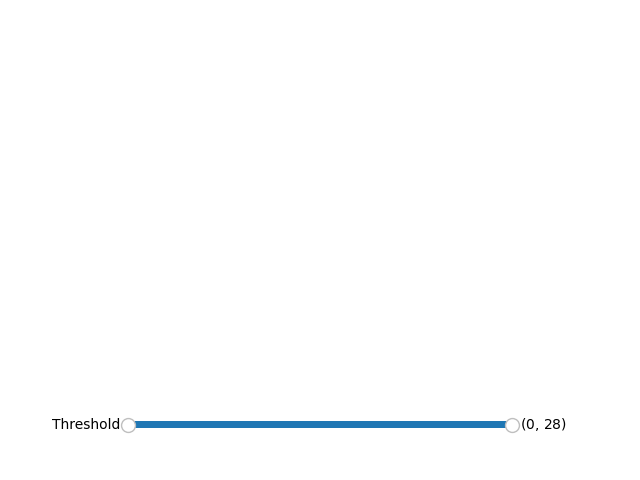

In [9]:
data_read = nib.load(epi_path)
dim = data_read.header['dim'][3] 
volume_number = 0

Thr = Thresholds()
obj = Data(data_read,volume_number)
Thr.attach(obj)

#test.display_all_slices(data_read,volume_number,dim)
plt.tight_layout()
slider_ax = plt.axes([0.20, 1/(dim/4+3), 0.60, 0.03])
slider = RangeSlider(slider_ax, "Threshold", 0, dim, valinit = [0, dim],valstep = 1)
slider.on_changed(update)
plt.show()

In [246]:
obj.highThres

28

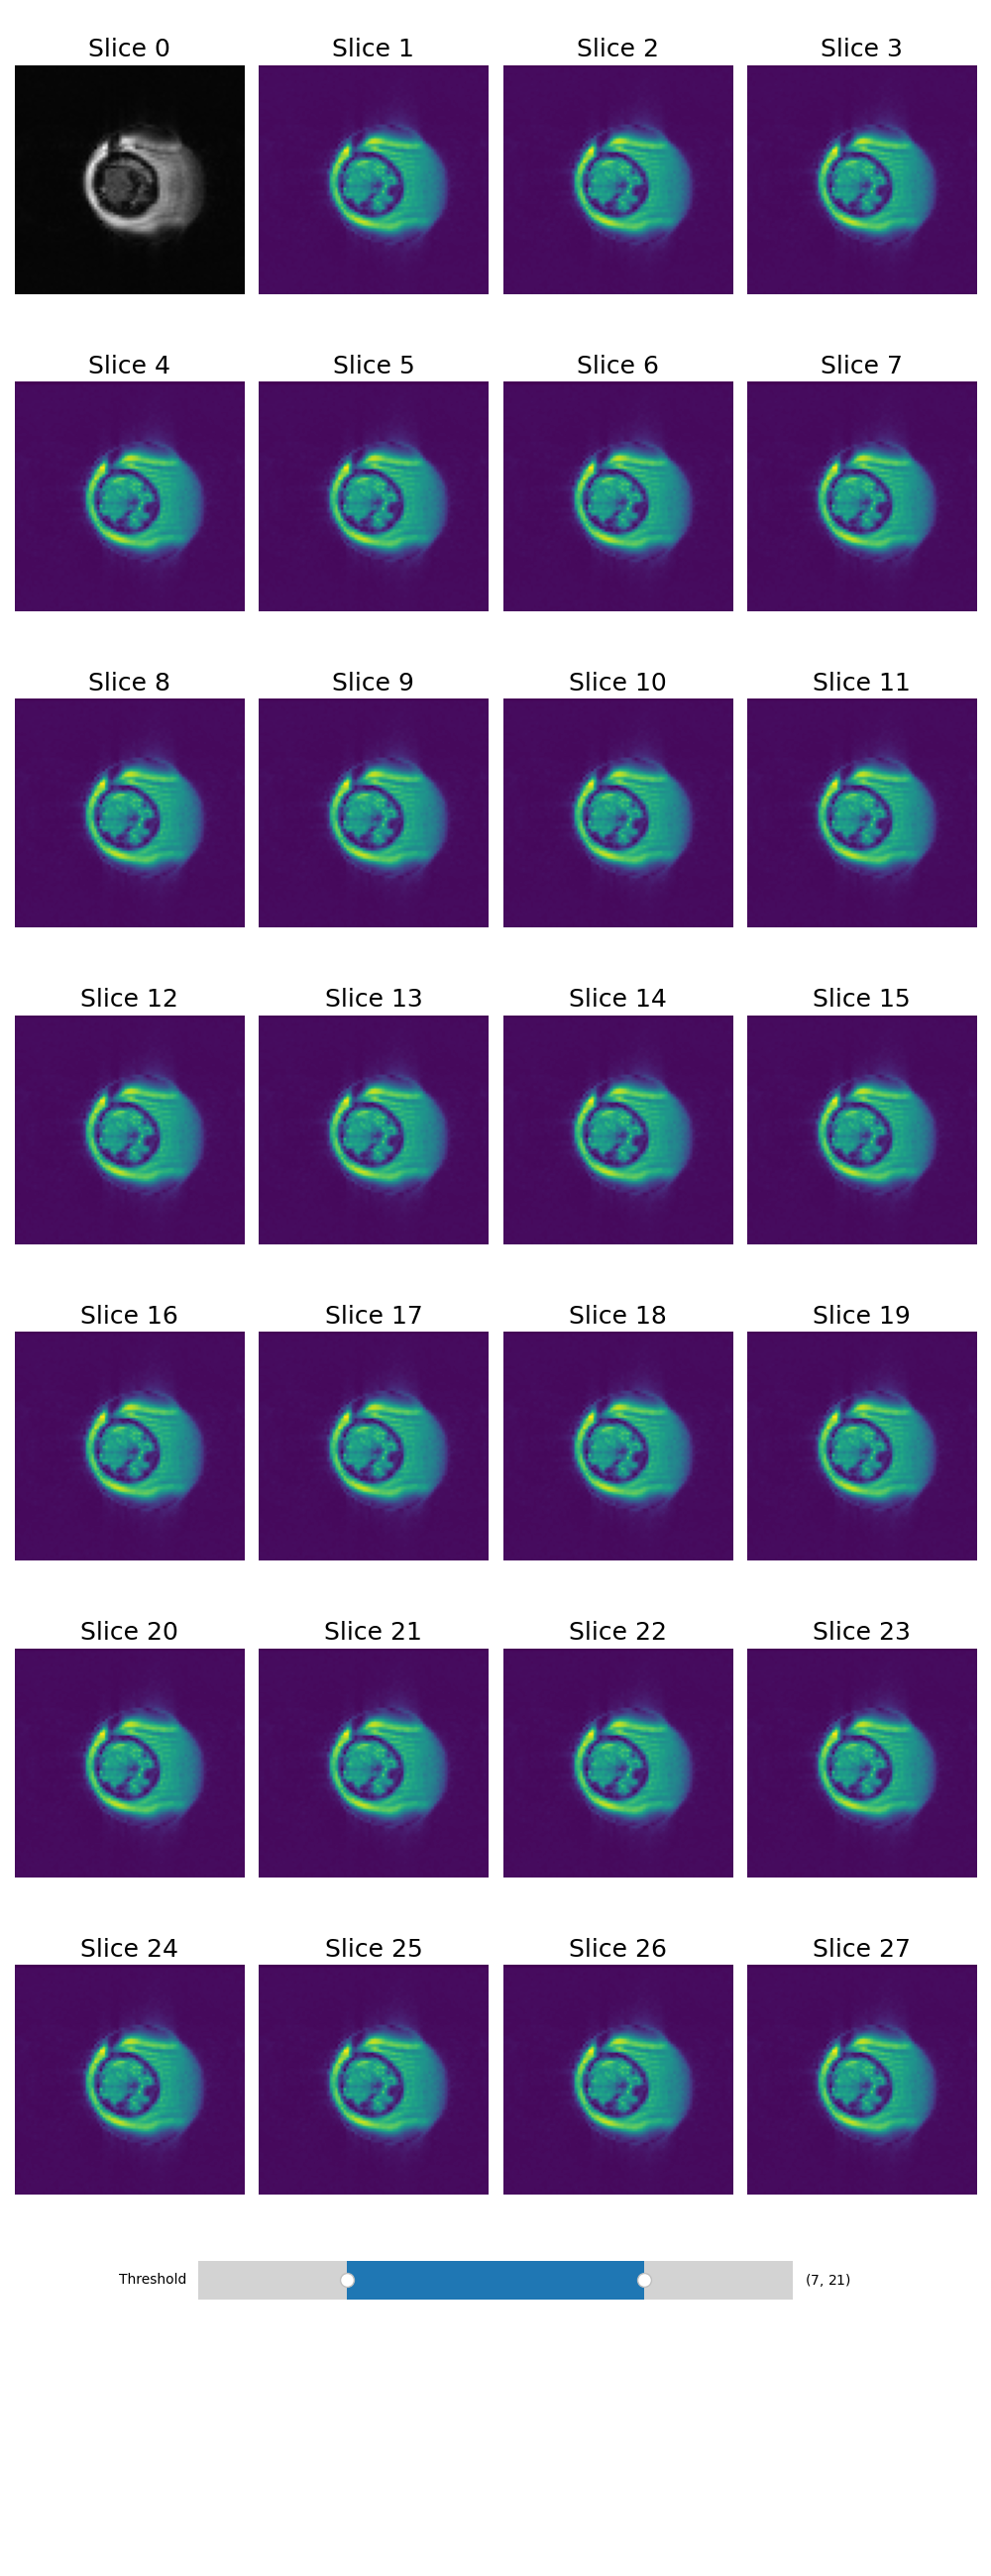

In [183]:
data_read = nib.load(epi_path)
dim = data_read.header['dim'][3] 
volume_number = 0
display_all_slices(data_read,volume_number,dim,lowThres = 1, highThres = 28)
plt.tight_layout()
slider_ax = plt.axes([0.20, 1/(dim/4+3), 0.60, 0.03])
slider = RangeSlider(slider_ax, "Threshold", 0, dim)
slider.on_changed(update)
plt.show()

In [9]:
dim = data_read.header['dim'][3].astype('int')

In [11]:
from ipywidgets import interactive
dim = data_read.header['dim'][3]
from IPython.display import display

def myfunction(x):
    return x

widget = interactive(myfunction, x = dim/4)
display(widget)

interactive(children=(FloatSlider(value=7.0, description='x', max=21.0, min=-7.0), Output()), _dom_classes=('w…

/var/folders/qh/8lv4v0ws1g17mk7kcgk2bf4w0000gn/T/ipykernel_4479/3303000520.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  im= plt.imshow(data_read.get_data()[:,:,i,volume_number])


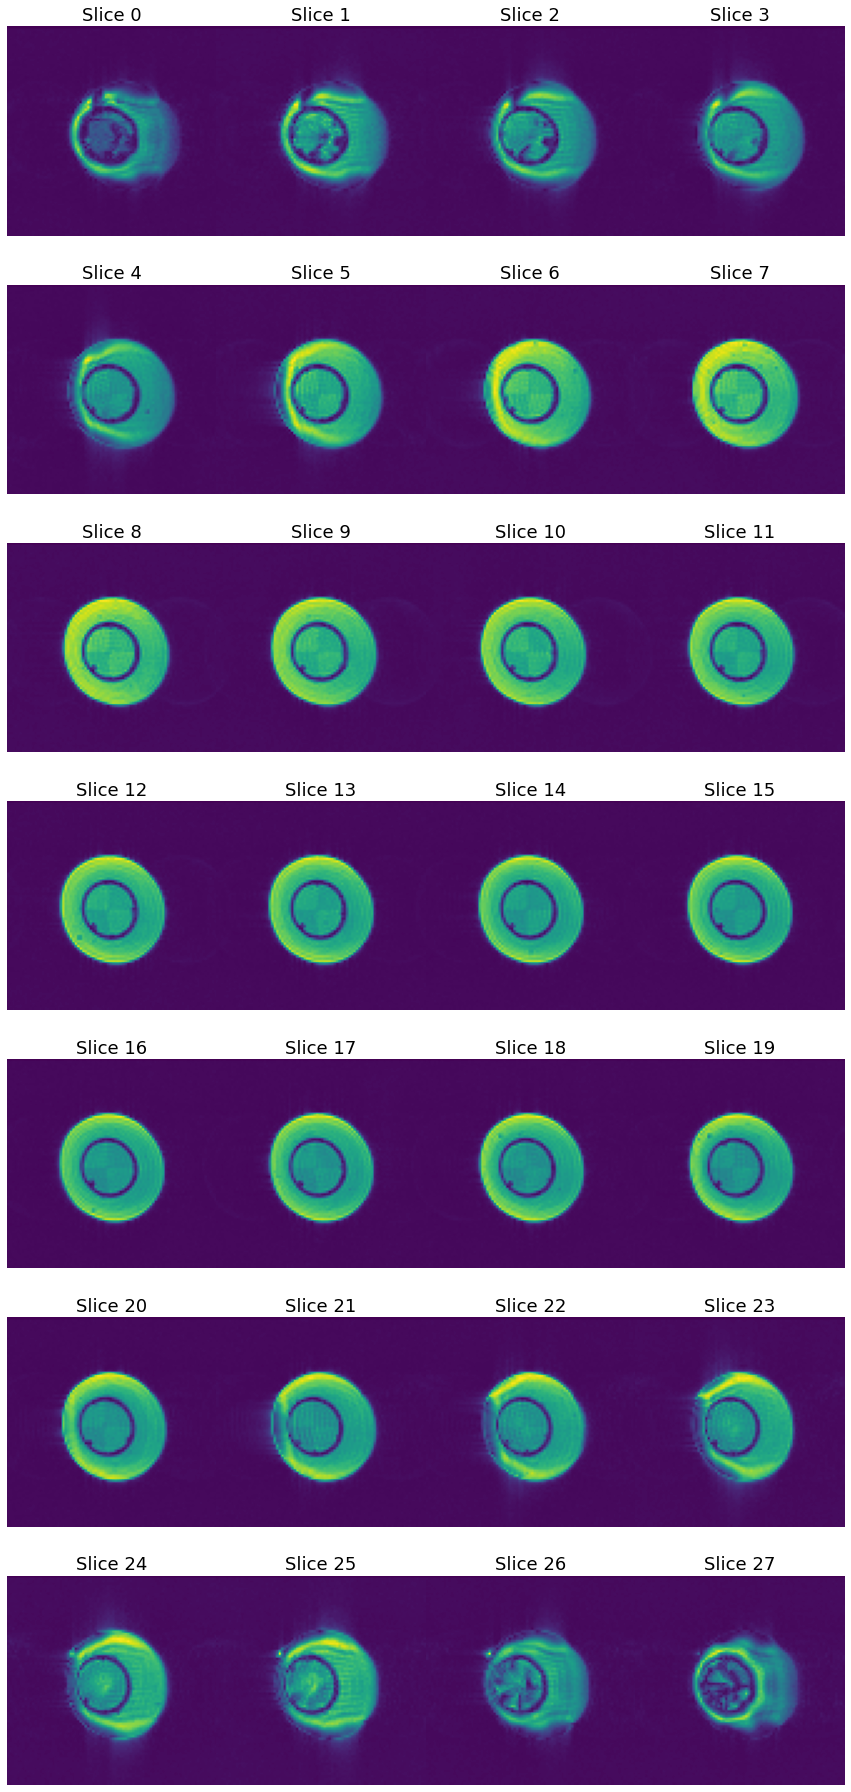

In [14]:
data_read = nib.load(epi_path)
volume_number = 0
count = 1
dim = data_read.header['dim'][3]
fig = plt.figure(figsize=(15,dim+10))

for i in range(dim):
    fig.subplots_adjust(hspace=0, wspace=0.0005)      
    ax = fig.add_subplot(int(dim/4 +1) ,4, count)
    im= plt.imshow(data_read.get_data()[:,:,i,volume_number])
    ax.set_title('Slice '+str(i),fontsize=18)
    ax.set_axis_off()
    count+=1

### Run the Extraction 

In [22]:
ground_truth, measured_fmri, imask, center, all_slices = create_denoising_dataset(epi_path,log_path,acqtimes_path,rot_dir=-1)

ValueError: Number of rows must be a positive integer, not 8.0

<Figure size 1080x2736 with 0 Axes>

### Save the Results

In [ ]:
nib.save(ground_truth,ground_truth_ts)
nib.save(measured_fmri,measured_fmri_ts)
nib.save(list_to_nib(imask,ground_truth.affine),masks)
sio.savemat(center_rotation,{'center':center}) 
sio.savemat(center_rotation,{'slices':all_slices})